Week 11 · Day 5 — Self-Attention vs Cross-Attention + Visualization
Why this matters

Self-attention: queries, keys, values come from the same sequence → tokens relate to each other.

Cross-attention: queries come from one sequence, keys/values from another (e.g. decoder attends to encoder).
Visualization shows what the model “looks at” when making decisions.

Theory Essentials

Self-attention: Q=K=V (same input).

Cross-attention: Q ≠ K,V (different sources).

Useful in encoder–decoder:

Encoder → self-attention.

Decoder → (1) self-attention, (2) cross-attention to encoder outputs.

Heatmaps of attention weights make interactions interpretable.

🔹 Encoder

Input: a sequence (e.g. an English sentence).

Each token is turned into embeddings → goes through layers of self-attention.

Self-attention means: each word looks at other words in the same sentence to build richer representations.

Output: a sequence of contextual embeddings (same length as input, but now each vector “knows” about the rest of the sequence).

👉 Think of the encoder as a reader that deeply understands the input sequence.

🔹 Decoder

Input: another sequence (e.g. the translated French words generated so far).

Step 1: Self-attention → decoder looks at the words it has produced so far (with causal masking so it doesn’t peek ahead).

Step 2: Cross-attention → decoder queries the encoder’s outputs.

Queries = from decoder.

Keys/Values = from encoder.

This lets the decoder align its current position (“what French word should I say next?”) with the source sentence.

👉 Think of the decoder as a writer that builds the output, while constantly checking back with the encoder’s understanding.

Self-attention attn shape: torch.Size([1, 4, 6, 6])
Cross-attention attn shape: torch.Size([1, 4, 4, 6])


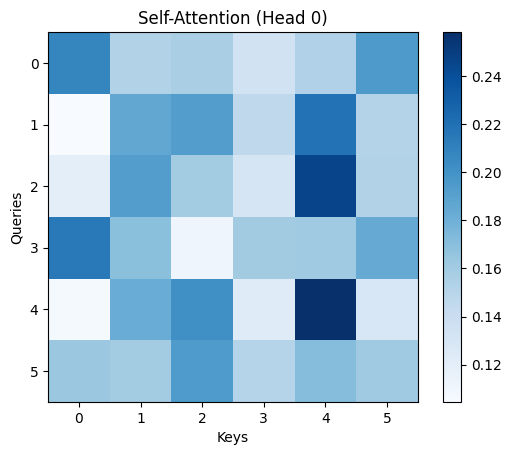

In [1]:
# Setup
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        B, Lq, D = Q.shape
        Lk = K.shape[1]

        Q = self.W_q(Q).view(B, Lq, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(K).view(B, Lk, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(V).view(B, Lk, self.num_heads, self.d_k).transpose(1,2)

        scores = (Q @ K.transpose(-2,-1)) / (self.d_k**0.5)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = F.softmax(scores, dim=-1)

        out = (attn @ V).transpose(1,2).contiguous().view(B, Lq, D)
        return self.W_o(out), attn

# Example
torch.manual_seed(0)
mha = MultiHeadAttention(d_model=16, num_heads=4)

# Self-attention
x = torch.randn(1, 6, 16)  # 6 tokens
out_self, attn_self = mha(x, x, x)

# Cross-attention: queries from decoder (4 tokens), keys/values from encoder (6 tokens)
q = torch.randn(1, 4, 16)
k = v = torch.randn(1, 6, 16)
out_cross, attn_cross = mha(q, k, v)

print("Self-attention attn shape:", attn_self.shape)   # (1, 4, 6, 6)
print("Cross-attention attn shape:", attn_cross.shape) # (1, 4, 4, 6)

# Visualize one head from self-attention
plt.imshow(attn_self[0,0].detach(), cmap="Blues")
plt.colorbar()
plt.title("Self-Attention (Head 0)")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.show()


Example: “I love pizza” → “J’aime la pizza”

1. Encoder (English sentence)

Input: ["I", "love", "pizza"]

Each word embedding goes into self-attention layers.

Output: enriched representations of “I”, “love”, “pizza” (they now carry context about each other).

2. Decoder (French sentence being generated)

Step 1: Generate first token “J’”.

Decoder self-attention: attends only to “J’” (mask prevents looking ahead).

Cross-attention: looks at encoder output — aligns mostly with “I”.

Step 2: Generate next token “aime”.

Decoder self-attention: attends to ["J’"].

Cross-attention: aligns strongly with “love” in encoder output.

Step 3: Generate “la”.

Self-attention: attends to ["J’", "aime"].

Cross-attention: focuses on “pizza” in encoder output.

Step 4: Generate “pizza”.

Self-attention: attends to ["J’", "aime", "la"].

Cross-attention: again aligns with “pizza”.

👉 That’s why cross-attention is so important: it lets the decoder map each output word back to the relevant source word.
And self-attention ensures the French words it generates make sense together.

1) Core (10–15 min)
Task: Print attention weights for self-attention vs cross-attention. What’s the difference in shape?

In [4]:
print("Weights self attention")
print(attn_self[0,0])

print("Weights cross-attention")
print(attn_cross[0,0])

print("Self:", attn_self.shape, "Cross:", attn_cross.shape)


Weights self attention
tensor([[0.2076, 0.1525, 0.1567, 0.1343, 0.1538, 0.1951],
        [0.1045, 0.1858, 0.1925, 0.1464, 0.2188, 0.1519],
        [0.1197, 0.1923, 0.1596, 0.1304, 0.2459, 0.1521],
        [0.2145, 0.1690, 0.1117, 0.1599, 0.1614, 0.1835],
        [0.1069, 0.1821, 0.2016, 0.1229, 0.2584, 0.1281],
        [0.1634, 0.1594, 0.1946, 0.1504, 0.1709, 0.1614]],
       grad_fn=<SelectBackward0>)
Weights cross-attention
tensor([[0.2067, 0.1353, 0.1908, 0.1716, 0.1306, 0.1649],
        [0.0393, 0.1924, 0.0469, 0.2257, 0.4075, 0.0882],
        [0.1391, 0.1237, 0.0963, 0.2044, 0.3133, 0.1231],
        [0.2444, 0.1238, 0.1981, 0.1518, 0.1278, 0.1540]],
       grad_fn=<SelectBackward0>)
Self: torch.Size([1, 4, 6, 6]) Cross: torch.Size([1, 4, 4, 6])


2) Practice (10–15 min)
Task: In cross-attention, make encoder length = 8 and decoder length = 3. Verify attention shape.

In [5]:
q = torch.randn(1,3,16)
k = v = torch.randn(1,8,16)
_, attn = mha(q,k,v)
print(attn.shape)


torch.Size([1, 4, 3, 8])


3) Stretch (optional, 10–15 min)
Task: Write a function to visualize all heads in a grid for one batch.

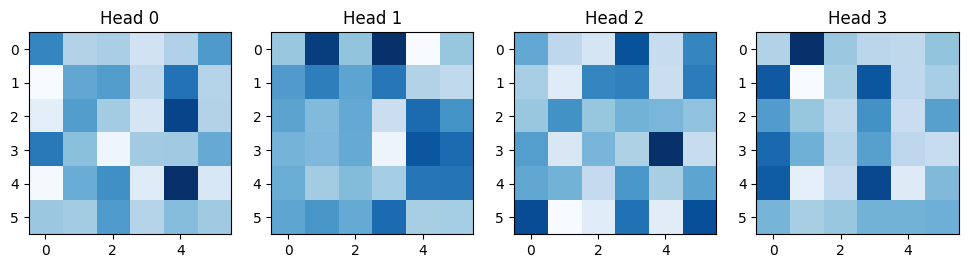

In [6]:
def plot_heads(attn):
    heads = attn.shape[1]
    fig, axs = plt.subplots(1, heads, figsize=(12,3))
    for i in range(heads):
        axs[i].imshow(attn[0,i].detach(), cmap="Blues")
        axs[i].set_title(f"Head {i}")
    plt.show()

plot_heads(attn_self)


Mini-Challenge (≤40 min)

Build: A notebook section that compares self-attention and cross-attention with visualizations.
Acceptance Criteria:

Run both self- and cross-attention on toy data.

Show heatmaps for each.

Brief explanation of when to use each.

Self-attention: out torch.Size([1, 6, 16]) attn torch.Size([1, 4, 6, 6])


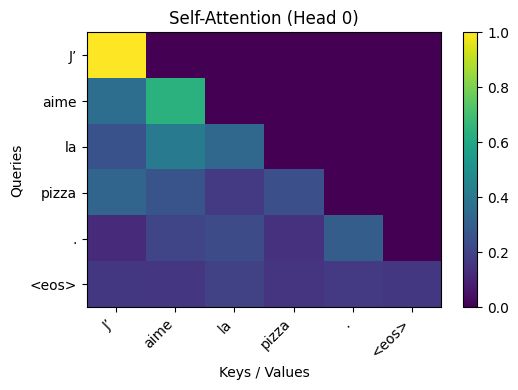

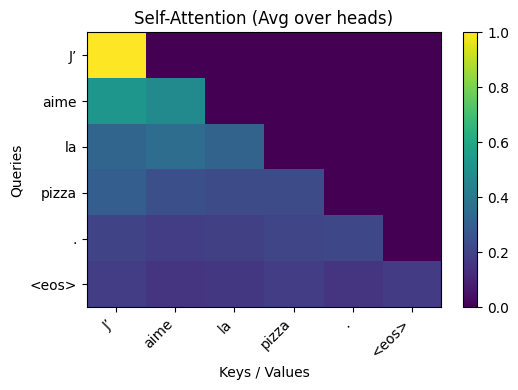

Cross-attention: out torch.Size([1, 4, 16]) attn torch.Size([1, 4, 4, 8])


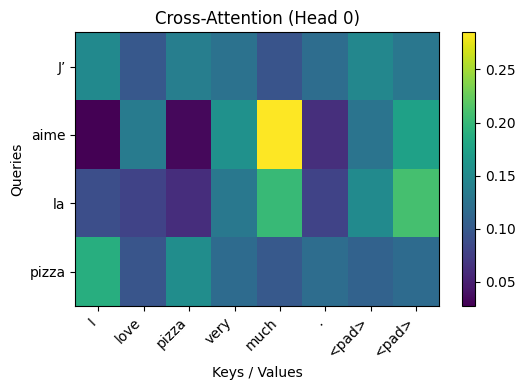

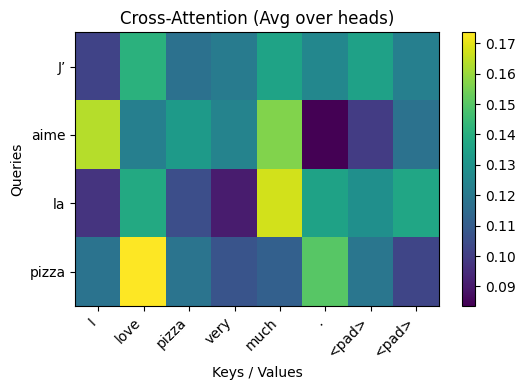

✔ Shapes OK. Visuals generated.


In [7]:
# Mini-Challenge: Self- vs Cross-Attention + Visualizations

import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

# ----- MultiHeadAttention (unchanged) -----
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        B, Lq, D = Q.shape
        Lk = K.shape[1]

        Q = self.W_q(Q).view(B, Lq, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(B, Lk, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(B, Lk, self.num_heads, self.d_k).transpose(1, 2)

        scores = (Q @ K.transpose(-2, -1)) / (self.d_k ** 0.5)              # [B, H, Lq, Lk]
        if mask is not None:                                                # mask: 1=keep, 0=mask
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)                                    # [B, H, Lq, Lk]
        out = (attn @ V).transpose(1, 2).contiguous().view(B, Lq, D)        # [B, Lq, D]
        return self.W_o(out), attn

# ----- Helpers -----
def causal_mask(Lq, Lk=None):
    """Lower-triangular mask for decoder self-attention (no look-ahead)."""
    Lk = Lq if Lk is None else Lk
    m = torch.ones(Lq, Lk, dtype=torch.bool).tril()                         # 1=keep, 0=mask
    return m.unsqueeze(0).unsqueeze(0)                                      # [1,1,Lq,Lk]

def plot_heatmap(A, q_labels, k_labels, title):
    """A: [Lq, Lk] attention; labels are lists of strings."""
    plt.figure(figsize=(5.5, 4))
    plt.imshow(A, aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Keys / Values")
    plt.ylabel("Queries")
    plt.xticks(range(len(k_labels)), k_labels, rotation=45, ha='right')
    plt.yticks(range(len(q_labels)), q_labels)
    plt.tight_layout()
    plt.show()

# ----- Seed & model -----
torch.manual_seed(0)
mha = MultiHeadAttention(d_model=16, num_heads=4)

# ----- (A) SELF-ATTENTION (decoder style with causal mask) -----
tokens_self = ["J’", "aime", "la", "pizza", ".", "<eos>"]   # toy labels for visualization
x = torch.randn(1, len(tokens_self), 16)
mask_self = causal_mask(Lq=len(tokens_self))                 # [1,1,Lq,Lk]
out_self, attn_self = mha(x, x, x, mask=mask_self)           # attn: [1, H, Lq, Lk]

print("Self-attention: out", out_self.shape, "attn", attn_self.shape)
# Show head 0 and the average over heads
plot_heatmap(attn_self[0, 0].detach(), tokens_self, tokens_self, "Self-Attention (Head 0)")
plot_heatmap(attn_self.mean(1)[0].detach(), tokens_self, tokens_self, "Self-Attention (Avg over heads)")

# ----- (B) CROSS-ATTENTION (decoder Q, encoder K/V) -----
src_tokens = ["I", "love", "pizza", "very", "much", ".", "<pad>", "<pad>"]  # len=8
tgt_tokens = ["J’", "aime", "la", "pizza"]                                  # len=4

Q = torch.randn(1, len(tgt_tokens), 16)   # decoder states -> queries
K = torch.randn(1, len(src_tokens), 16)   # encoder outputs -> keys
V = K.clone()                              # (toy: V=K)

out_cross, attn_cross = mha(Q, K, V)       # no mask for cross-attn in this toy
print("Cross-attention: out", out_cross.shape, "attn", attn_cross.shape)

plot_heatmap(attn_cross[0, 0].detach(), tgt_tokens, src_tokens, "Cross-Attention (Head 0)")
plot_heatmap(attn_cross.mean(1)[0].detach(), tgt_tokens, src_tokens, "Cross-Attention (Avg over heads)")

# ----- One-liner acceptance checks -----
assert attn_self.shape[-2:] == (len(tokens_self), len(tokens_self))  # [Lq,Lk] = [6,6]
assert attn_cross.shape[-2:] == (len(tgt_tokens), len(src_tokens))   # [Lq,Lk] = [4,8]
print("✔ Shapes OK. Visuals generated.")


Perfect ✅ — let’s role-play what happens **step by step** if “ChatGPT” is asked:

**👉 Task: translate “I love pizza” into French.**

---

## 1. **Encoder phase** (source: “I love pizza”)

* Input embeddings: `["I", "love", "pizza"]`.
* **Encoder self-attention**:

  * Q = K = V = same input.
  * **Mask used**: **padding mask only** (to ignore `<pad>` if the batch had shorter sentences).
  * No causal mask: encoder can see the whole input.
* Output: contextual embeddings `[h_I, h_love, h_pizza]`.

---

## 2. **Decoder phase** (target: “J’aime la pizza”)

The decoder works token by token, autoregressively.
We’ll generate **one French word at a time**:

---

### Step A: Generate first token → “J’”

1. **Decoder self-attention**

   * Input so far = `["<start>"]`.
   * Q = K = V = embeddings of `["<start>"]`.
   * **Mask used**: **causal mask** (triangular). But since there’s only 1 token, it can only see itself.
2. **Cross-attention**

   * Query = current decoder hidden state for `["<start>"]`.
   * Keys/Values = encoder outputs (`["I","love","pizza"]`).
   * No causal mask (we want full source visible).
   * Likely aligns mostly with “I”.
3. Prediction = “J’”.

---

### Step B: Generate second token → “aime”

1. **Decoder self-attention**

   * Input so far = `["J’"]`.
   * Now we add “aime”, so queries = `[J’, aime]`.
   * **Causal mask**:

     ```
     J’   aime
     1
     1    1
     ```

     → “aime” can see itself + “J’”, but not future tokens.
2. **Cross-attention**

   * Each query attends over encoder outputs.
   * “aime” focuses strongly on “love”.
3. Prediction = “aime”.

---

### Step C: Generate third token → “la”

* Decoder self-attention:

  * Tokens so far = `[J’, aime, la]`.
  * **Causal mask** ensures “la” cannot peek at “pizza” (future).
* Cross-attention:

  * “la” attends strongly to encoder “pizza” (since French grammar needs an article).
* Prediction = “la”.

---

### Step D: Generate fourth token → “pizza”

* Decoder self-attention:

  * Tokens so far = `[J’, aime, la, pizza]`.
  * Causal mask: “pizza” can only see J’, aime, la.
* Cross-attention:

  * “pizza” aligns directly to encoder “pizza”.
* Prediction = “pizza”.

---

## 3. **Final output**

`["J’", "aime", "la", "pizza"]`

---

## ✅ Masks used in each phase:

* **Encoder self-attention**: padding mask (no causal).
* **Decoder self-attention**: **causal mask** (triangular).
* **Decoder cross-attention**: padding mask (ignore encoder pads), no causal.

---

👉 So the flow is:
**Encoder self-attn (pad mask) → Decoder self-attn (causal mask) → Decoder cross-attn (pad mask)**, repeated for each new token until `<eos>`.



Notes / Key Takeaways

Self-attention: token-to-token within one sequence.

Cross-attention: queries from one seq, keys/values from another.

Shapes differ: (q_len × k_len).

Visualization shows which tokens attend to which.

Cross-attention powers encoder–decoder models (translation, summarization).

Reflection

Why do we need both self- and cross-attention in an encoder–decoder Transformer?

How would attention heatmaps help debug model behavior?

Why do we need both self- and cross-attention in an encoder–decoder Transformer?

Self-attention lets tokens in the same sequence interact:

In the encoder, it builds contextual representations of the input sentence (each word “understands” its neighbors).

In the decoder, it keeps the generated words coherent, with a causal mask to avoid looking ahead.

Cross-attention connects the decoder to the encoder: it aligns each output token with the most relevant parts of the source sentence.
👉 Without self-attention, context within each sequence is lost. Without cross-attention, the decoder would not know what in the source to translate.

How would attention heatmaps help debug model behavior?

Heatmaps show which tokens attend to which others.

They let us see if the model is focusing on the right parts (e.g., “pizza” in French aligns with “pizza” in English).

If the model makes mistakes (wrong word, hallucination), the heatmap can reveal whether it was attending to irrelevant tokens, or ignoring key ones.
👉 They make the model’s “reasoning” visible, turning a black box into something interpretable.